In [21]:
from pathlib import Path
import shutil as sh
import json
import pandas as pd
import numpy as np

models_path = Path('../models')
stats_path = Path('./stats')

if not stats_path.exists():
    stats_path.mkdir()


for model in models_path.iterdir():
    if not model.is_dir():
        continue
    sh.copy(str(model / 'stats.json') , str(stats_path / f'{model.stem}.json') )
    
stats_files = list(stats_path.iterdir())

In [22]:
stats_df = pd.DataFrame()
for stat_f in stats_files:
    print("========= " + stat_f.stem + " ==========")
    
    with open(stat_f, 'r') as f:
        stats = json.load(f)
        
        for k, run in stats.items():
            print(f'--- {k}: {len(run)} ---') 
            
            print(k, run)
            
            loss = 0
            cluster_sizes = []
            for cluster in run:
                loss += cluster['loss']*cluster['cluster_size']
                cluster_sizes.append(cluster['cluster_size'])
            loss /= sum(cluster_sizes) 
            
            stats_df = pd.concat([stats_df, pd.DataFrame([
                    {'model': stat_f.stem, 
                    'run': k, 
                    'cluster sizes':cluster_sizes, 
                    'nclusters': len(run),
                    'avg loss': loss,
                    'min loss' : min([c['loss'] for c in run]),
                    'max loss': max([c['loss'] for c in run]),
                    'std loss': np.std([c['loss'] for c in run]),}
                ])
            ])
                
            print("Average Cluster Loss: ", loss)
stats_df.reset_index(drop=True, inplace=True)
stats_df[['run', 'nclusters']] = stats_df[['run', 'nclusters']].astype(int)
        
    

========= minisom_alpha ==========
--- 0: 4 ---
0 [{'run': 0, 'cluster': 2, 'loss': 0.08111786097288132, 'mse': 0.08111786097288132, 'cluster_size': 3904}, {'run': 0, 'cluster': 1, 'loss': 0.0806250348687172, 'mse': 0.0806250348687172, 'cluster_size': 3304}, {'run': 0, 'cluster': 4, 'loss': 0.08132192492485046, 'mse': 0.08132192492485046, 'cluster_size': 2455}, {'run': 0, 'cluster': 3, 'loss': 0.08024489879608154, 'mse': 0.08024489879608154, 'cluster_size': 2108}]
Average Cluster Loss:  0.08086575624815377
========= pca_agg_alpha ==========
--- 0: 2 ---
0 [{'run': 0, 'cluster': 0, 'loss': 0.08164900541305542, 'mse': 0.08164900541305542, 'cluster_size': 7208}, {'run': 0, 'cluster': 1, 'loss': 0.08058904111385345, 'mse': 0.08058904111385345, 'cluster_size': 4563}]
Average Cluster Loss:  0.08123811278734319
--- 1: 3 ---
1 [{'run': 1, 'cluster': 0, 'loss': 0.08207228779792786, 'mse': 0.08207228779792786, 'cluster_size': 4850}, {'run': 1, 'cluster': 1, 'loss': 0.08059775084257126, 'mse': 0.

# Model Results

In [23]:
stats_df

,model,run,cluster sizes,nclusters,avg loss,min loss,max loss,std loss
0,minisom_alpha,0,"[3904, 3304, 2455, 2108]",4,0.080866,0.080245,0.081322,0.000421
1,pca_agg_alpha,0,"[7208, 4563]",2,0.081238,0.080589,0.081649,0.000530
2,pca_agg_alpha,1,"[4850, 4563, 2358]",3,0.081671,0.080598,0.082921,0.000960
3,ts_kmeans_mag,0,"[5872, 5899]",2,0.083744,0.082027,0.085468,0.001720
4,ts_kmeans_mag,1,"[2825, 5896, 3050]",3,0.074112,0.060688,0.082410,0.008869
5,ts_kmeans_mag,2,"[2795, 3286, 3077, 2613]",4,0.061496,0.051011,0.069884,0.006939
6,pca_kmeans_alpha,0,"[4563, 7208]",2,0.081247,0.080559,0.081682,0.000561
7,pca_kmeans_alpha,1,"[2364, 7208, 2199]",3,0.081414,0.078603,0.083117,0.001886
8,pca_kmeans_alpha,2,"[2364, 3588, 2199, 3620]",4,0.080942,0.078243,0.083875,0.002623
9,minmax_pca_kmeans,0,"[4571, 7200]",2,0.082614,0.080716,0.083819,0.001551


## Top 10

In [24]:
top10 = list(stats_df['avg loss'].nsmallest(10).index)
stats_df.loc[top10]

,model,run,cluster sizes,nclusters,avg loss,min loss,max loss,std loss
29,pca_kmeans_mag,2,"[2797, 3287, 3075, 2612]",4,0.060719,0.047582,0.070359,0.008466
5,ts_kmeans_mag,2,"[2795, 3286, 3077, 2613]",4,0.061496,0.051011,0.069884,0.006939
25,pca_agg_mag,1,"[5875, 3351, 2545]",3,0.073471,0.057200,0.084464,0.011148
28,pca_kmeans_mag,1,"[2829, 5896, 3046]",3,0.073710,0.059129,0.082388,0.009499
4,ts_kmeans_mag,1,"[2825, 5896, 3050]",3,0.074112,0.060688,0.082410,0.008869
17,minmax_pca_agg,2,"[2365, 3644, 3564, 2198]",4,0.075142,0.069221,0.078786,0.004479
11,minmax_pca_kmeans,2,"[2525, 3325, 2057, 3864]",4,0.077191,0.071477,0.080504,0.003874
10,minmax_pca_kmeans,1,"[3375, 4677, 3719]",3,0.078386,0.073651,0.081381,0.003224
16,minmax_pca_agg,1,"[4563, 3644, 3564]",3,0.079492,0.078298,0.080658,0.000971
26,quantile_pca_kmeans,0,"[4573, 7198]",2,0.080598,0.080498,0.080662,0.000082


# Prediction Plots

In [25]:
import pickle as pkl
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Dict, List, Tuple
from sklearn.preprocessing import QuantileTransformer

clusters_path = Path('../clusters')
data_path = Path('../../data/compiled/')

## Helper Functions

In [27]:
def plot_cluster_preds(pred_df : pd.DataFrame, model_name : str):
    """Plot the predictions of a cluster."""
    ns = pred_df.iloc[:, 0:640]
    vs = pred_df.iloc[:, 640:1280]
    ts = pred_df.iloc[:, 1280:1920]
    
    vs.reset_index(drop=True, inplace=True)
    ts.reset_index(drop=True, inplace=True)
    
    fig, axs = plt.subplots(3, 1, figsize=(12, 6))
    fig.suptitle(f'Predictions for {model_name}')
    
    for _, row in ns.iterrows():
        sns.lineplot(row.values, ax=axs[0], label=None, linewidth=0.1)
        
    for _, row in vs.iterrows():
        sns.lineplot(row.values, ax=axs[1], label=None, linewidth=0.1)

    for _, row in ts.iterrows():
        sns.lineplot(row.values, ax=axs[2], label=None, linewidth=0.1)
    
    plt.show()    

## Plot Predictions

Index(['filename', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '1910', '1911', '1912', '1913', '1914', '1915', '1916', '1917', '1918',
       '1919'],
      dtype='object', length=1921)


2023-02-14 18:35:24.831079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Cluster shape: (2797, 1920)
88/88 [==============================] - 1s 3ms/step


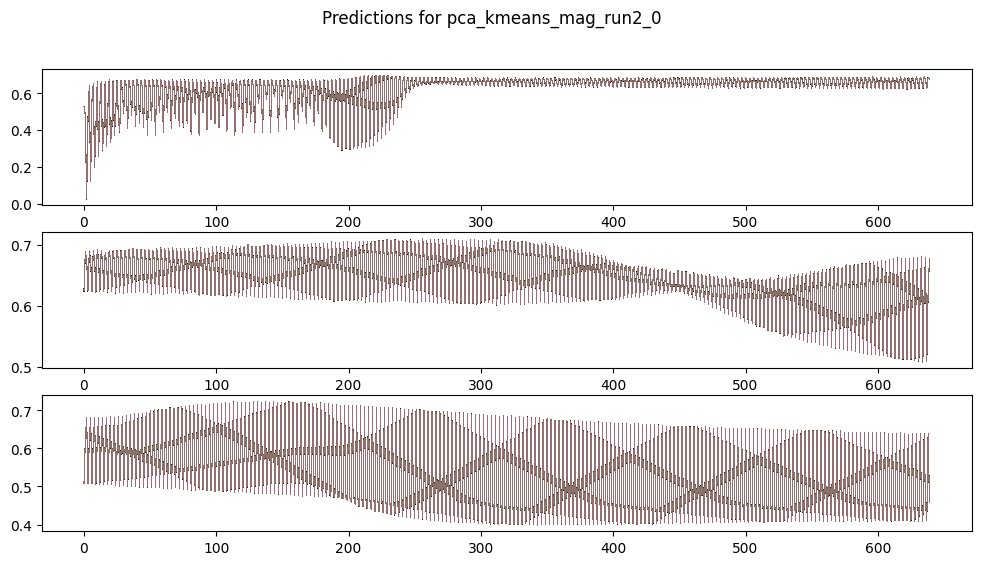

(2797, 1920) (2797, 1920)


KeyboardInterrupt: 

In [31]:

# input_data, output_data, scaler_inputs, scaler_outputs = load_original_data(data_path)
# cluster_files = set([f.stem for f in clusters_path.iterdir() if f.is_file()])

# # plot best model runs
# for _, row in stats_df.loc[top10].iterrows():
#     # open cluster file
#     with open(clusters_path / f'{row["model"]}.pkl', 'rb') as cf:
#         runs = pkl.load(cf)
         
#         # get clusters from best run
#         for cluster_id, cluster in runs[row['run']]['clusters'].items():
            
#             # print(runs[row['run']])
#             # print(cluster)
#             # get cluster model
#             model = keras.models.load_model(
#                 str(models_path / f'{row["model"]}' / f'{row["model"]}_run{row["run"]}_{cluster_id}.h5')
#             )
            
#             cluster_inputs, cluster_outputs = join_files_in_cluster(cluster, input_data, output_data)
        
#             predictions = model.predict(cluster_inputs)
            
            
#             # pred_df = pd.DataFrame(predictions)
#             # pred_df.columns = pred_df.columns.astype(str)
#             # print(pred_df.columns)
#             # predictions = scaler_outputs.inverse_transform(pred_df)
#             pred_df = pd.DataFrame(predictions)
            
#             plot_cluster_preds(pred_df, f'{row["model"]}_run{row["run"]}_{cluster_id}')
#             # plot predictions vs actuals
#             print(predictions.shape, cluster_outputs.shape)
    
